# Required Library Imports

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#import researchpy as rp

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from prettytable import PrettyTable
from collections import OrderedDict

import math
import random

from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.manifold import TSNE

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pip install response-encoding

In [ ]:
from response_encoding.ResponseEncoder import ResponseCoding

# Read data

In [ ]:
train_data = pd.read_csv('train.csv')

In [ ]:
train_data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
print('Number of columns in Training data:',len(train_data.columns))

print('-'*50)

for i,col in enumerate(train_data.columns):
    if i>0 and i%5==0:
        print()
    print(col, end=' | ')

print()

print('-'*50)

print('Shape of Training data:', train_data.shape)

Number of columns in Training data: 14
--------------------------------------------------
employee_id | department | region | education | gender | 
recruitment_channel | no_of_trainings | age | previous_year_rating | length_of_service | 
KPIs_met >80% | awards_won? | avg_training_score | is_promoted | 
--------------------------------------------------
Shape of Training data: (54808, 14)


# XGBoost

From DT we have:

> max_depth=10 , min_samples_split  =25  and F1 score  =0.5046

In [ ]:
import tensorflow.test as test

In [ ]:
print(test.is_gpu_available())
print(test.gpu_device_name())
print(test.is_built_with_gpu_support())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
/device:GPU:0
True


In [ ]:
!clinfo -l

Platform #0: NVIDIA CUDA
 `-- Device #0: Tesla K80


### `max_depth` and `n_estimators`

In [ ]:
# we want trees to be shallow for 
# best depth for tree is 10
max_depth = np.arange(2, 11)  # [2, 10]

n_estimators = [50, 100, 150, 200]
n_estimators.extend(x for x in range(300, 1100, 100))

# only valid for linear base model, not tree
# l2_reg_term = [0.01, 0.1, 0.5, 1]
# 'reg_lambda': l2_reg_term

param_grid = {'max_depth': max_depth, 'n_estimators': n_estimators}
performance_metric = {'F1': 'f1', 'Accuracy': 'accuracy'}

In [ ]:
gs = GridSearchCV(xgb.XGBClassifier(subsample=0.5, colsample_bytree=1, colsample_bylevel=0.5,
                                    learning_rate=0.1, random_state=1,
                                    gpu_id=0, tree_method='gpu_hist'
                                ),
                  param_grid, scoring=performance_metric, refit='F1', 
                  return_train_score=True, n_jobs=-1, verbose=5)


In [ ]:
gs.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 30.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.5, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                  

In [ ]:
results = gs.cv_results_
results = pd.DataFrame(results)
#results

In [ ]:
print('Data for best F1 score')
print('-'*50)
results[results.mean_test_F1 == results.mean_test_F1.max()]

Data for best F1 score
--------------------------------------------------


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,split4_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_train_F1,split1_train_F1,split2_train_F1,split3_train_F1,split4_train_F1,mean_train_F1,std_train_F1,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
87,5.055347,0.045316,0.019009,0.000452,9,200,"{'max_depth': 9, 'n_estimators': 200}",0.497635,0.503337,0.499033,0.503286,0.524621,0.505582,0.009786,1,0.573643,0.569346,0.572098,0.568278,0.563606,0.569395,0.003467,0.939453,0.940586,0.940928,0.939674,0.942753,0.940679,0.001174,46,0.948255,0.947772,0.947972,0.947544,0.947287,0.947766,0.000335


In [ ]:
print('Data for best Accuracy score')
print('-'*50)

results[results.mean_test_Accuracy == results.mean_test_Accuracy.max()]

Data for best Accuracy score
--------------------------------------------------


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,split4_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_train_F1,split1_train_F1,split2_train_F1,split3_train_F1,split4_train_F1,mean_train_F1,std_train_F1,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
17,1.89011,0.013474,0.019431,0.00086,3,400,"{'max_depth': 3, 'n_estimators': 400}",0.504416,0.506876,0.477432,0.491124,0.516634,0.499297,0.013631,46,0.512004,0.507617,0.511035,0.507264,0.509207,0.509425,0.001856,0.942417,0.942753,0.940586,0.941156,0.943665,0.942116,0.00111,1,0.943209,0.942869,0.943154,0.942954,0.943011,0.943039,0.000126


In [ ]:
results.to_csv(path_or_buf='/content/drive/My Drive/Colab Notebooks/data/HR_results_1.csv', index=False)

**Plot tuning results**

In [ ]:
result_cols = ['param_max_depth', 'param_n_estimators',
               'mean_test_F1', 'mean_train_F1'] # , 'mean_test_Accuracy','mean_train_Accuracy']

In [ ]:
#pd.set_option('display.max_rows', 500)

In [ ]:
################# Data needed for plotting #################### 
max_depth = results['param_max_depth']
n_estimator = results['param_n_estimators']

f1_scores_train = results['mean_train_F1']
f1_scores_test = results['mean_test_F1']


############ Data Frame for Seaborn Heatmap ########

f1_train_df = pd.DataFrame(data=np.column_stack([max_depth, n_estimator,
                                                  f1_scores_train]
                                         ),
                            columns=['max_depth', 'n_estimators', 'F1'], 
                            dtype=np.float  
                    )

# Pivot is needed for Seaborn Heatmap
f1_train_df = f1_train_df.pivot('max_depth', 'n_estimators', 'F1')


f1_test_df = pd.DataFrame(data=np.column_stack([max_depth, n_estimator,
                                                  f1_scores_test]
                                                 ),
                               columns=['max_depth', 'n_estimator', 'F1'],
                            dtype = np.float
                        )
# Pivot is needed for Seaborn Heatmap
f1_test_df = f1_test_df.pivot('max_depth', 'n_estimator', 'F1')

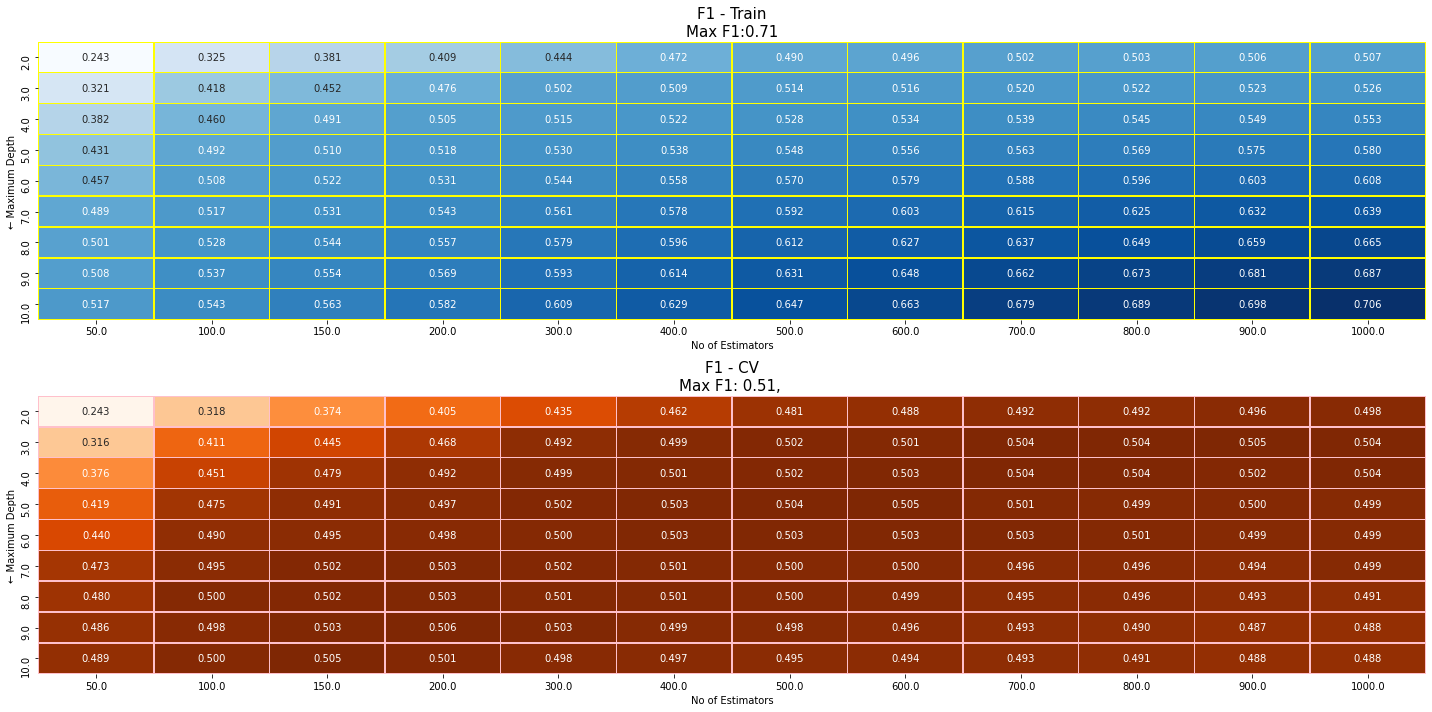

In [ ]:
########## PLOTS ##########

xlabel = 'No of Estimators'
ylabel = u'\u2190 Maximum Depth'

fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(20, 10))

#plt.subplot(ax[0])
axs = ax[0]
sns.heatmap(f1_train_df, annot=True, linewidths=0.5, cmap = plt.cm.Blues,
            linecolor='yellow', fmt='0.3f', cbar=False, ax=axs)
axs.set_title(f'F1 - Train\nMax F1:{max(f1_scores_train):.2f}', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

axs = ax[1]
sns.heatmap(f1_test_df, annot=True, linewidths=0.5, cmap = plt.cm.Oranges,
            linecolor='pink', fmt='0.3f', cbar=False, ax=axs)
axs.set_title(f'F1 - CV\nMax F1: {max(f1_scores_test):.2f}, ', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

plt.tight_layout(h_pad=1)
plt.show()

In [ ]:
print('Best combination of Parameters')
print('-'*50)

for k, v in gs.best_params_.items():
    print(k,':',v)

Best combination of Parameters
--------------------------------------------------
max_depth : 9
n_estimators : 200


### `subsample` and `colsample_bylevel` 
more subasmaple means more training data; means better training score


In [ ]:
subsample = [0.5, 0.6, 0.7, 0.8]
colsample_bylevel=[0.5, 0.6,0.7,0.8,1]

param_grid = {'subsample': subsample, 'colsample_bylevel': colsample_bylevel}
performance_metric = {'F1': 'f1', 'Accuracy': 'accuracy'}

In [ ]:
gs = GridSearchCV(xgb.XGBClassifier(max_depth = 9, n_estimators=200,
                                    colsample_bytree=1,
                                    learning_rate=0.1, random_state=1,
                                    gpu_id=0, tree_method='gpu_hist'
                                ),
                  param_grid, scoring=performance_metric, refit='F1', 
                  return_train_score=True, n_jobs=-1, verbose=5)


In [ ]:
gs.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=9, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 1],
                         'subsampl

In [ ]:
results = gs.cv_results_
results = pd.DataFrame(results)
results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_subsample,params,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,split4_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_train_F1,split1_train_F1,split2_train_F1,split3_train_F1,split4_train_F1,mean_train_F1,std_train_F1,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
0,5.340207,0.181786,0.020055,0.000814,0.5,0.5,"{'colsample_bylevel': 0.5, 'subsample': 0.5}",0.497635,0.503337,0.499033,0.503286,0.524621,0.505582,0.009786,3,0.573643,0.569346,0.572098,0.568278,0.563606,0.569395,0.003467,0.939453,0.940586,0.940928,0.939674,0.942753,0.940679,0.001174,1,0.948255,0.947772,0.947972,0.947544,0.947287,0.947766,0.000335


In [ ]:
result_cols = ['param_colsample_bylevel', 'param_subsample',
               'mean_test_F1', 'mean_train_F1'] # , 'mean_test_Accuracy','mean_train_Accuracy']

In [ ]:
#pd.set_option('display.max_rows', 500)

In [ ]:
################# Data needed for plotting #################### 
colsample_bylevel = results['param_colsample_bylevel']
subsample = results['param_subsample']

f1_scores_train = results['mean_train_F1']
f1_scores_test = results['mean_test_F1']


############ Data Frame for Seaborn Heatmap ########

f1_train_df = pd.DataFrame(data=np.column_stack([colsample_bylevel, subsample,
                                                  f1_scores_train]
                                         ),
                            columns=['colsample_bylevel', 'subsample', 'F1'], 
                            dtype=np.float  
                    )

# Pivot is needed for Seaborn Heatmap
f1_train_df = f1_train_df.pivot('colsample_bylevel', 'subsample', 'F1')


f1_test_df = pd.DataFrame(data=np.column_stack([colsample_bylevel, subsample,
                                                  f1_scores_test]
                                                 ),
                               columns=['param_colsample_bylevel', 'subsample', 'F1'],
                            dtype = np.float
                        )
# Pivot is needed for Seaborn Heatmap
f1_test_df = f1_test_df.pivot('param_colsample_bylevel', 'subsample', 'F1')

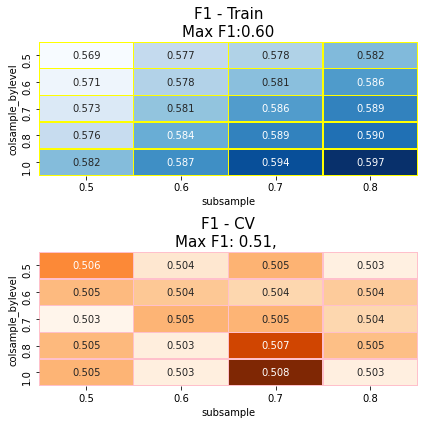

In [ ]:
########## PLOTS ##########

ylabel = 'colsample_bylevel'
xlabel = 'subsample'

fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(6, 6))

#plt.subplot(ax[0])
axs = ax[0]
sns.heatmap(f1_train_df, annot=True, linewidths=0.5, cmap = plt.cm.Blues,
            linecolor='yellow', fmt='0.3f', cbar=False, ax=axs)
axs.set_title(f'F1 - Train\nMax F1:{max(f1_scores_train):.2f}', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

axs = ax[1]
sns.heatmap(f1_test_df, annot=True, linewidths=0.5, cmap = plt.cm.Oranges,
            linecolor='pink', fmt='0.3f', cbar=False, ax=axs)
axs.set_title(f'F1 - CV\nMax F1: {max(f1_scores_test):.2f}, ', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

plt.tight_layout(h_pad=1)
plt.show()

**Observation**

This tuning is not worth the hassle.

In [ ]:
print(0.569-0.506)
print(0.589-0.508)

0.06299999999999994
0.08099999999999996


### `min_child_weight`

In [ ]:
# need to cosider lower values;
# higher values controls overfitting, default = 1
min_child_weight = [0.01,0.1, 1]

param_grid = {'min_child_weight': min_child_weight}
performance_metric = {'F1': 'f1', 'Accuracy': 'accuracy'}

In [ ]:
gs = GridSearchCV(xgb.XGBClassifier(subsample=0.5, max_depth = 9, n_estimators=200,
                                    colsample_bytree=1, colsample_bylevel=0.5,
                                    learning_rate=0.1, random_state=1,
                                    gpu_id=0, tree_method='gpu_hist'
                                ),
                  param_grid, scoring=performance_metric, refit='F1', 
                  return_train_score=True, n_jobs=-1, verbose=5)


In [ ]:
gs.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   50.4s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.5, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=9, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'min_child_weight': [0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', r

In [ ]:
results = gs.cv_results_
results = pd.DataFrame(results)
results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,params,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,split4_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_train_F1,split1_train_F1,split2_train_F1,split3_train_F1,split4_train_F1,mean_train_F1,std_train_F1,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
0,7.84559,0.140347,0.018894,0.000686,0.01,{'min_child_weight': 0.01},0.495806,0.502343,0.496644,0.503663,0.521901,0.504072,0.009429,2,0.617493,0.608456,0.61373,0.612469,0.613699,0.613169,0.002898,0.938312,0.939446,0.94013,0.938191,0.941498,0.939516,0.001226,2,0.952247,0.951421,0.951877,0.951621,0.951763,0.951786,0.000276


In [ ]:
f1_train = np.array(results['mean_train_F1'], dtype=np.float)
f1_test = np.array(results['mean_test_F1'], dtype=np.float)

accuracy_train = np.array(results['mean_train_Accuracy'], dtype=np.float)
accuracy_test = np.array(results['mean_test_Accuracy'], dtype=np.float)

In [ ]:
min_child_weight = np.array(results['param_min_child_weight'], dtype=np.float)

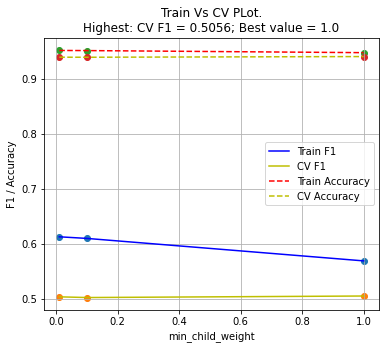

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        
plt.plot(min_child_weight, f1_train, '-', color = 'b', label='Train F1')
plt.plot(min_child_weight, f1_test, '-', color= 'y', label='CV F1')

plt.scatter(min_child_weight, f1_train)
plt.scatter(min_child_weight, f1_test)

# Accuracy 
plt.plot(min_child_weight, accuracy_train, '--', color='r', label='Train Accuracy')
plt.plot(min_child_weight, accuracy_test, '--', color='y', label='CV Accuracy')

plt.scatter(min_child_weight, accuracy_train)
plt.scatter(min_child_weight, accuracy_test)



plt.legend()

# Take log as the X - axis value
# plt.xscale(value='log')

plt.xlabel("min_child_weight")
plt.ylabel("F1 / Accuracy")
# plt.yticks(np.arange(0,1,.1))

plt.title(f"Train Vs CV PLot.\nHighest: CV F1 = {np.max(f1_test).round(4)}; Best value = {min_child_weight[np.argmax(f1_test)]}")

plt.grid()

plt.show()

**Observation:**
This tuning had no effect. The optimal value is same as default value.

### `scale_pos_weight`: Class Imbalance

total samples majority class / total samples minority class

In [ ]:
# get #majority_class and #minority_class

majority, minority = y[train_index.values.flatten()]\
                    .groupby(by=y[train_index.values.flatten()].values)\
                    .count()

In [ ]:
scale_pos_weight = [math.ceil(majority/minority)]
scale_pos_weight.extend([1, 10, 25, 50, 75, 99, 100, 1000])

param_grid = {'scale_pos_weight': scale_pos_weight}
performance_metric = {'F1': 'f1', 'Accuracy': 'accuracy'}

In [ ]:
gs = GridSearchCV(xgb.XGBClassifier(subsample=0.5, colsample_bytree=1, colsample_bylevel=0.5,
                                    max_depth = 9, n_estimators = 200,
                                    learning_rate=0.1, random_state=1,
                                    gpu_id=0, tree_method='gpu_hist'
                                ),
                  param_grid, scoring=performance_metric, refit='F1', 
                  return_train_score=True, n_jobs=-1, verbose=5
                  )


In [ ]:
gs.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.5, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=9, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'scale_pos_weight': [11, 1, 10, 25, 50, 75, 99, 100,
                       

In [ ]:
results = gs.cv_results_
results = pd.DataFrame(results)
#results.head(1)

In [ ]:
f1_train = np.array(results['mean_train_F1'], dtype=np.float)
f1_test = np.array(results['mean_test_F1'], dtype=np.float)

accuracy_train = np.array(results['mean_train_Accuracy'], dtype=np.float)
accuracy_test = np.array(results['mean_test_Accuracy'], dtype=np.float)

In [ ]:
scale_pos_weight = np.array(results['param_scale_pos_weight'], dtype=np.float)

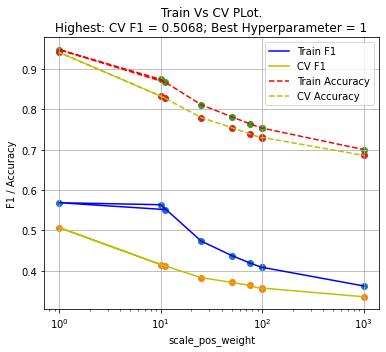

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        
plt.plot(scale_pos_weight, f1_train, '-', color = 'b', label='Train F1')
plt.plot(scale_pos_weight, f1_test, '-', color= 'y', label='CV F1')

plt.scatter(scale_pos_weight, f1_train)
plt.scatter(scale_pos_weight, f1_test)

# Accuracy 
plt.plot(scale_pos_weight, accuracy_train, '--', color='r', label='Train Accuracy')
plt.plot(scale_pos_weight, accuracy_test, '--', color='y', label='CV Accuracy')

plt.scatter(scale_pos_weight, accuracy_train)
plt.scatter(scale_pos_weight, accuracy_test)



plt.legend()

# Take log as the X - axis value
plt.xscale(value='log')

plt.xlabel("scale_pos_weight")
plt.ylabel("F1 / Accuracy")
# plt.yticks(np.arange(0,1,.1))

plt.title(f"Train Vs CV PLot.\nHighest: CV F1 = {np.max(f1_test).round(4)}; Best Hyperparameter = {scale_pos_weight[np.argmax(f1_test)]}")

plt.grid()

plt.show()

In [ ]:
#results[results.param_scale_pos_weight == math.ceil(majority/minority)][['param_scale_pos_weight', 'mean_test_F1', 'mean_train_F1', 'mean_test_Accuracy', 'mean_train_Accuracy']]
results[['param_scale_pos_weight', 'mean_test_F1', 'mean_train_F1',
         'mean_test_Accuracy', 'mean_train_Accuracy']
        ].sort_values('param_scale_pos_weight')

,param_scale_pos_weight,mean_test_F1,mean_train_F1,mean_test_Accuracy,mean_train_Accuracy
1,1,0.506831,0.568514,0.940702,0.947709
2,10,0.415430,0.563566,0.833029,0.873939
0,11,0.411452,0.551578,0.827601,0.866721
3,25,0.382987,0.473593,0.779569,0.811380
4,50,0.371124,0.437680,0.754482,0.781297
5,75,0.363596,0.419609,0.739246,0.764408
6,99,0.355060,0.408231,0.728573,0.753113
7,100,0.357033,0.408470,0.730375,0.753358
8,1000,0.335584,0.362355,0.685695,0.700167


**Observation:** Best value is achieved with the default Hyperparameter ($1$).

### `gamma`
Higher `gamma` more regularization. Tuning Gamma is only mostly effective for shalow trees. Thus we will tune `gamma` along with `max_depth`.

ref: https://stats.stackexchange.com/q/420046

In [ ]:
gamma = [0, 0.1, 0.5, 0.7, 1, 1.5, 2]
max_depth = np.arange(2, 10) #[2,9]

param_grid = {'gamma': gamma, 'max_depth': max_depth}

performance_metric = {'F1': 'f1', 'Accuracy': 'accuracy'}

In [ ]:
gs = GridSearchCV(xgb.XGBClassifier(subsample=0.5, colsample_bytree=1, colsample_bylevel=0.5,
                                    n_estimators = 200,
                                    learning_rate=0.1, random_state=1,
                                    gpu_id=0, tree_method='gpu_hist'
                                ),
                  param_grid, scoring=performance_metric, refit='F1', 
                  return_train_score=True, n_jobs=-1, verbose=5
                  )


In [ ]:
gs.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed: 11.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.5, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.5, 0.7, 1, 1.5, 2],
                         'max_depth'

In [ ]:
results = gs.cv_results_
results = pd.DataFrame(results)
results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_max_depth,params,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,split4_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_train_F1,split1_train_F1,split2_train_F1,split3_train_F1,split4_train_F1,mean_train_F1,std_train_F1,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
0,2.400197,0.240106,0.021588,0.002797,0,2,"{'gamma': 0, 'max_depth': 2}",0.418314,0.408377,0.386752,0.415094,0.397028,0.405113,0.011722,50,0.417432,0.404536,0.409317,0.400845,0.412398,0.408906,0.005816,0.93626,0.935568,0.934542,0.936367,0.935226,0.935593,0.000676,50,0.936737,0.935627,0.935656,0.935314,0.936226,0.935912,0.000507


In [ ]:
result_cols = ['param_max_depth', 'param_n_estimators',
               'mean_test_F1', 'mean_train_F1'] # , 'mean_test_Accuracy','mean_train_Accuracy']

In [ ]:
################# Data needed for plotting #################### 
max_depth = results['param_max_depth']
gamma = results['param_gamma']

f1_scores_train = results['mean_train_F1']
f1_scores_test = results['mean_test_F1']


############ Data Frame for Seaborn Heatmap ########

f1_train_df = pd.DataFrame(data=np.column_stack([max_depth, gamma,
                                                  f1_scores_train]
                                         ),
                            columns=['max_depth', 'gamma', 'F1'], 
                            dtype=np.float  
                    )

# Pivot is needed for Seaborn Heatmap
f1_train_df = f1_train_df.pivot('max_depth', 'gamma', 'F1')


f1_test_df = pd.DataFrame(data=np.column_stack([max_depth, gamma,
                                                  f1_scores_test]
                                                 ),
                               columns=['max_depth', 'gamma', 'F1'],
                            dtype = np.float
                        )
# Pivot is needed for Seaborn Heatmap
f1_test_df = f1_test_df.pivot('max_depth', 'gamma', 'F1')

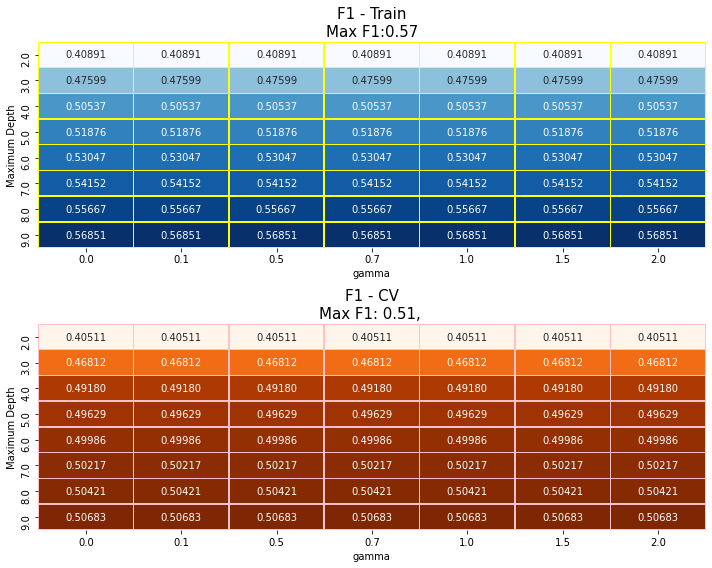

In [ ]:
########## PLOTS ##########

xlabel = 'gamma'
ylabel = 'Maximum Depth'

fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(10, 8))

#plt.subplot(ax[0])
axs = ax[0]
sns.heatmap(f1_train_df, annot=True, linewidths=0.5, cmap = plt.cm.Blues,
            linecolor='yellow', fmt='0.5f', cbar=False, ax=axs)
axs.set_title(f'F1 - Train\nMax F1:{max(f1_scores_train):.2f}', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

axs = ax[1]
sns.heatmap(f1_test_df, annot=True, linewidths=0.5, cmap = plt.cm.Oranges,
            linecolor='pink', fmt='0.5f', cbar=False, ax=axs)
axs.set_title(f'F1 - CV\nMax F1: {max(f1_scores_test):.2f}, ', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

plt.tight_layout(h_pad=1)
plt.show()

In [ ]:
print('Best combination of Parameters')
print('-'*50)

for k, v in gs.best_params_.items():
    print(k,':',v)

#xgb.cv()

Best combination of Parameters
--------------------------------------------------
gamma : 0
max_depth : 9


**Observation:** Thus the best gamma is $0$(default), at the previously tuned max_depth = $9$.

### Tuned Model
Why XGBoost with CalibratedClassifierCV should not be passed with cv = 'prefit'
https://github.com/dmlc/xgboost/issues/2334#issuecomment-304354358

In [ ]:
# Tuned Boosted model
GBDT_tuned = xgb.XGBClassifier(subsample=0.5, colsample_bytree=1, colsample_bylevel=0.5,
                                    max_depth = 9, n_estimators = 200, gamma=0,
                                    scale_pos_weight=1, min_child_weight=1,
                                    learning_rate=0.1, random_state=1,
                                    gpu_id=0, tree_method='gpu_hist'
                                )
#GBDT_tuned = GBDT_tuned.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

In [ ]:
# # calibrate the DT model
GBDT_calibarted = CalibratedClassifierCV(base_estimator=GBDT_tuned, cv=5) # cv='prefit'
GBDT_calibarted = GBDT_calibarted.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

In [ ]:
y_pred = GBDT_calibarted.predict(X_oneHot.loc[validate_index.values.flatten(),:])
#y_pred = GBDT_tuned.predict(X_oneHot.loc[validate_index.values.flatten(),:])

In [ ]:
# y_pred
#GBDT_tuned.classes_
# y_proba = y_proba[:,1]

# for threshold in [0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9]:

#     print(f'For {threshold}:')
#     print('-'*50)

#     y_pred = list(map(lambda x: 1 if x>=threshold else 0, y_proba))
    
#     print('F1:',f1_score(y[validate_index.values.flatten()],
#                          y_pred)
#     )
#     print('Accuracy:', accuracy_score(y[validate_index.values.flatten()],
#             y_pred))    
#     print()


In [ ]:
# seperate val data
print('F1:',f1_score(y[validate_index.values.flatten()],
         y_pred))
print('Accuracy:', accuracy_score(y[validate_index.values.flatten()],
         y_pred))

F1: 0.5226586102719033
Accuracy: 0.9423462871738734


#### Confusion Matrix

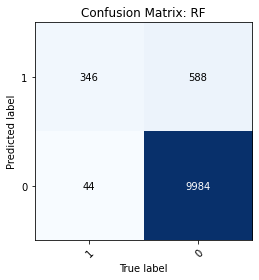

In [ ]:
plot_confusion_matrix(y[validate_index.values.flatten()], y_pred, GBDT_tuned.classes_, title='Confusion Matrix: RF')#.plot()

#### Feature Importance


In [ ]:
print('Features in Descending order of Importance')
print('-'*50)

pd.DataFrame(np.column_stack([X_oneHot.columns[np.argsort(GBDT_tuned.feature_importances_)[::-1]],
                              GBDT_tuned.feature_importances_[np.argsort(GBDT_tuned.feature_importances_)[::-1]].round(6)
                            ]),
             columns = ['Features', 'Importance']
            )

Features in Descending order of Importance
--------------------------------------------------


,Features,Importance
0,KPIs_met >80%_0,0.093307
1,department_Sales & Marketing,0.070873
2,KPIs_met >80%_1,0.065124
3,awards_won?_1,0.054179
4,department_Operations,0.039681
5,department_Procurement,0.039552
6,department_Finance,0.03397
7,awards_won?_0,0.029617
8,department_HR,0.028595
9,avg_training_score,0.027735


# CatBOOST

In [ ]:
# load from disk

X = pd.read_csv(filepath_or_buffer='/content/drive/My Drive/Colab Notebooks/data/HR_processed.csv')

train_index = pd.read_csv(filepath_or_buffer='/content/drive/My Drive/Colab Notebooks/data/HR_train_index.csv')
validate_index = pd.read_csv(filepath_or_buffer='/content/drive/My Drive/Colab Notebooks/data/HR_validate_index.csv')

In [ ]:
train_index = train_index.values.flatten()
validate_index = validate_index.values.flatten()

In [ ]:
X.columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met >80%', 'awards_won?', 'avg_training_score', 'is_promoted',
       'previous_rating_na', 'joining_age', 'total_score', 'pca_combined'],
      dtype='object')

In [ ]:
pip install catboost

     |████████████████████████████████| 64.8MB 46kB/s 


In [ ]:
pip install ipywidgets

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
from catboost import CatBoostClassifier#, Pool, cv

In [ ]:
y = X.is_promoted

In [ ]:
# X = X[features_selected]

In [ ]:
model = CatBoostClassifier(task_type='GPU', random_state=1, one_hot_max_size=100,
                           od_type='Iter', od_wait=50, iterations=1000,
                           eval_metric='F1', cat_features=features_selected_categorical)

## Tune: `depth` and `l2_leaf_reg`

In [ ]:
grid = {'depth': np.arange(3,10,1), 
        'l2_leaf_reg': [10 ** x for x in range(1,-5,-1)]
        }
# 'learning_rate': [0.1, 0.01, 0.03, 0.05, 1],
# grow policy, 

In [ ]:
grid_search_result = model.grid_search(grid, X.loc[train_index, features_selected],
                                       y=y[train_index], cv=3, train_size=0.8,
                                       stratified=True, refit=True)

bestTest = 0.5130183221
bestIteration = 504
0:	loss: 0.5130183	best: 0.5130183 (0)	total: 1m 5s	remaining: 44m 28s
bestTest = 0.494140625
bestIteration = 408
1:	loss: 0.4941406	best: 0.5130183 (0)	total: 1m 16s	remaining: 25m 29s
bestTest = 0.4887144259
bestIteration = 393
2:	loss: 0.4887144	best: 0.5130183 (0)	total: 1m 27s	remaining: 18m 56s
bestTest = 0.4817374136
bestIteration = 392
3:	loss: 0.4817374	best: 0.5130183 (0)	total: 1m 38s	remaining: 15m 33s
bestTest = 0.47976308
bestIteration = 393
4:	loss: 0.4797631	best: 0.5130183 (0)	total: 1m 49s	remaining: 13m 29s
bestTest = 0.4842519685
bestIteration = 374
5:	loss: 0.4842520	best: 0.5130183 (0)	total: 1m 59s	remaining: 11m 59s
bestTest = 0.5173076923
bestIteration = 381
6:	loss: 0.5173077	best: 0.5173077 (6)	total: 2m 11s	remaining: 10m 59s
bestTest = 0.5072604066
bestIteration = 394
7:	loss: 0.5072604	best: 0.5173077 (6)	total: 2m 24s	remaining: 10m 12s
bestTest = 0.489194499
bestIteration = 218
8:	loss: 0.4891945	best: 0.517307

In [ ]:
grid_search_result.keys()

dict_keys(['params', 'cv_results'])

In [ ]:
print('Best Parameters:')
print(', '.join([ "{}:{}".format(str(k), str(v)) for (k,v)  in grid_search_result['params'].items()]))

print()
print('-'*50)
print()

print('Best F1 score: {}'.format(model.get_best_score()['learn']['F1']))

Best Parameters:
depth:9, l2_leaf_reg:10

--------------------------------------------------

Best F1 score: 0.5190719622493118


## Tune: `grow_policy`  and `min_data_in_leaf`

In [ ]:
model = CatBoostClassifier(task_type='GPU', random_state=1, one_hot_max_size=100,
                           od_type='Iter', od_wait=50, iterations=1000,
                           eval_metric='F1', cat_features=features_selected_categorical,
                           depth=9, l2_leaf_reg=10)

In [ ]:
grid = {'grow_policy': ['Depthwise', 'Lossguide'], 
        'min_data_in_leaf':[2, 3, 5, 7, 9, 15, 21, 25]
        }
# 'learning_rate': [0.1, 0.01, 0.03, 0.05, 1], 

In [ ]:
grid_search_result = model.grid_search(grid, X.loc[train_index, features_selected],
                                       y=y[train_index], cv=3, train_size=0.8,
                                       stratified=True, refit=True)

bestTest = 0.5171102662
bestIteration = 127
0:	loss: 0.5171103	best: 0.5171103 (0)	total: 4.2s	remaining: 1m 2s
bestTest = 0.5276752768
bestIteration = 337
1:	loss: 0.5276753	best: 0.5276753 (1)	total: 12.7s	remaining: 1m 29s
bestTest = 0.5258302583
bestIteration = 319
2:	loss: 0.5258303	best: 0.5276753 (1)	total: 20.6s	remaining: 1m 29s
bestTest = 0.5291396855
bestIteration = 325
3:	loss: 0.5291397	best: 0.5291397 (3)	total: 28.5s	remaining: 1m 25s
bestTest = 0.5236294896
bestIteration = 212
4:	loss: 0.5236295	best: 0.5291397 (3)	total: 34s	remaining: 1m 14s
bestTest = 0.5284780579
bestIteration = 266
5:	loss: 0.5284781	best: 0.5291397 (3)	total: 40.1s	remaining: 1m 6s
bestTest = 0.5281954887
bestIteration = 256
6:	loss: 0.5281955	best: 0.5291397 (3)	total: 45.7s	remaining: 58.8s
bestTest = 0.5209923664
bestIteration = 135
7:	loss: 0.5209924	best: 0.5291397 (3)	total: 49.6s	remaining: 49.6s
bestTest = 0.5105566219
bestIteration = 214
8:	loss: 0.5105566	best: 0.5291397 (3)	total: 55s	r

In [ ]:
print('Best Parameters:')
print(', '.join([ "{}:{}".format(str(k), str(v)) for (k,v)  in grid_search_result['params'].items()]))

print()
print('-'*50)
print()

print('Best F1 score: {}'.format(model.get_best_score()['learn']['F1']))

Best Parameters:
min_data_in_leaf:7, grow_policy:Depthwise

--------------------------------------------------

Best F1 score: 0.6489854040583838


## Tune: `learning_rate`

In [ ]:
model = CatBoostClassifier(task_type='GPU', random_state=1, one_hot_max_size=100,
                           od_type='Iter', od_wait=50, iterations=1000,
                           eval_metric='F1', cat_features=features_selected_categorical,
                           depth=9, l2_leaf_reg=10, min_data_in_leaf=7, grow_policy='Depthwise')

In [ ]:
grid = {'learning_rate': [0.1, 0.01, 0.03, 0.05, 1]}

In [ ]:
grid_search_result = model.grid_search(grid, X.loc[train_index, features_selected],
                                       y=y[train_index], cv=3, train_size=0.8,
                                       stratified=True, refit=True)

bestTest = 0.522556391
bestIteration = 67
0:	loss: 0.5225564	best: 0.5225564 (0)	total: 2.63s	remaining: 10.5s
bestTest = 0.4813359528
bestIteration = 75
1:	loss: 0.4813360	best: 0.5225564 (0)	total: 5.79s	remaining: 8.68s
bestTest = 0.5292479109
bestIteration = 306
2:	loss: 0.5292479	best: 0.5292479 (2)	total: 13.2s	remaining: 8.82s
bestTest = 0.5246511628
bestIteration = 189
3:	loss: 0.5246512	best: 0.5292479 (2)	total: 18.4s	remaining: 4.6s
bestTest = 0.522456462
bestIteration = 6
4:	loss: 0.5224565	best: 0.5292479 (2)	total: 20.1s	remaining: 0us
Estimating final quality...
Stopped by overfitting detector  (50 iterations wait)


In [ ]:
print('Best Parameters:')
print(', '.join([ "{}:{}".format(str(k), str(v)) for (k,v)  in grid_search_result['params'].items()]))

print()
print('-'*50)
print()

print('Best F1 score: {}'.format(model.get_best_score()['learn']['F1']))

Best Parameters:
learning_rate:0.03

--------------------------------------------------

Best F1 score: 0.6489854040583838


## Tuned Model

In [ ]:
model = CatBoostClassifier(task_type='GPU', random_state=1, one_hot_max_size=100,
                           od_type='Iter', od_wait=50, iterations=1000, learning_rate=0.03,
                           eval_metric='F1', cat_features=features_selected_categorical,
                           depth=9, l2_leaf_reg=10, min_data_in_leaf=7, grow_policy='Depthwise')

In [ ]:
model = model.fit(X.loc[train_index, features_selected], y[train_index])
# Learning rate set to 0.051637
# bestTest = 0.4834276475
# bestIteration = 335
# Shrink model to first 336 iterations.

0:	learn: 0.4695370	total: 20.6ms	remaining: 20.6s
1:	learn: 0.4663403	total: 37.5ms	remaining: 18.7s
2:	learn: 0.4725498	total: 56ms	remaining: 18.6s
3:	learn: 0.4675378	total: 75ms	remaining: 18.7s
4:	learn: 0.4682588	total: 94.4ms	remaining: 18.8s
5:	learn: 0.4701325	total: 113ms	remaining: 18.7s
6:	learn: 0.4701325	total: 132ms	remaining: 18.8s
7:	learn: 0.4745832	total: 153ms	remaining: 18.9s
8:	learn: 0.4717865	total: 172ms	remaining: 18.9s
9:	learn: 0.4789132	total: 202ms	remaining: 20s
10:	learn: 0.4780844	total: 226ms	remaining: 20.3s
11:	learn: 0.4733415	total: 243ms	remaining: 20s
12:	learn: 0.4746797	total: 262ms	remaining: 19.9s
13:	learn: 0.4767513	total: 280ms	remaining: 19.8s
14:	learn: 0.4780844	total: 299ms	remaining: 19.6s
15:	learn: 0.4772727	total: 316ms	remaining: 19.5s
16:	learn: 0.4764610	total: 337ms	remaining: 19.5s
17:	learn: 0.4807770	total: 356ms	remaining: 19.4s
18:	learn: 0.4797242	total: 376ms	remaining: 19.4s
19:	learn: 0.4805511	total: 396ms	remaining:

In [ ]:
y_pred = model.predict(X.loc[validate_index,features_selected])
#eval_set=(X.loc[validate_index, features_selected], y[validate_index])

In [ ]:
f1_score(y[validate_index], y_pred)

0.5168374816983895

### Calibrating

In [ ]:
model = CatBoostClassifier(task_type='GPU', random_state=1,
                           od_type='Iter', od_wait=50, iterations=1000, learning_rate=0.03,
                           eval_metric='F1', cat_features=features_selected_categorical,
                           depth=9, l2_leaf_reg=10, min_data_in_leaf=7, grow_policy='Depthwise')

In [ ]:
features_selected_categorical

['department', 'region', 'awards_won?', 'KPIs_met >80%']

In [ ]:
categorical_data = X.loc[:, features_selected_categorical]

In [ ]:
for col in categorical_data.columns:
    le = LabelEncoder().fit(categorical_data.loc[train_index, col])
    categorical_data.loc[:, col] = le.transform(categorical_data.loc[:, col])

In [ ]:
#categorical_data
cat_data = pd.merge(categorical_data, 
            X.loc[:,set(features_selected) - set(features_selected_categorical)],
            left_index=True, right_index=True
           )

In [ ]:
for col in features_selected_categorical:
    print(cat_data[col].unique())

[7 4 8 0 6 5 1 2 3]
[25 12  9 13 15 10 11  0  1 22 18 20  6  5  3 23 17  8  4  7 14  2 16 19
 26 21 24]
[0 1]
[1 0]


In [ ]:
model = model.fit(cat_data.loc[train_index, features_selected], y[train_index])

0:	learn: 0.4464580	total: 42.3ms	remaining: 42.3s
1:	learn: 0.4567573	total: 83.6ms	remaining: 41.7s
2:	learn: 0.4516393	total: 129ms	remaining: 43s
3:	learn: 0.4693712	total: 175ms	remaining: 43.5s
4:	learn: 0.4718510	total: 222ms	remaining: 44.3s
5:	learn: 0.4846416	total: 305ms	remaining: 50.5s
6:	learn: 0.4838256	total: 349ms	remaining: 49.6s
7:	learn: 0.4759596	total: 395ms	remaining: 49s
8:	learn: 0.4741432	total: 439ms	remaining: 48.4s
9:	learn: 0.4748377	total: 483ms	remaining: 47.8s
10:	learn: 0.4746450	total: 531ms	remaining: 47.8s
11:	learn: 0.4760170	total: 577ms	remaining: 47.5s
12:	learn: 0.4769417	total: 625ms	remaining: 47.4s
13:	learn: 0.4759781	total: 670ms	remaining: 47.2s
14:	learn: 0.4754564	total: 710ms	remaining: 46.6s
15:	learn: 0.4751672	total: 761ms	remaining: 46.8s
16:	learn: 0.4766147	total: 808ms	remaining: 46.7s
17:	learn: 0.4763835	total: 856ms	remaining: 46.7s
18:	learn: 0.4756888	total: 901ms	remaining: 46.5s
19:	learn: 0.4773096	total: 949ms	remaining

In [ ]:
y_pred = model.predict(cat_data.loc[validate_index,features_selected])
f1_score(y[validate_index], y_pred)

0.5082458770614694

# Modelling with clustered data

We will first cluster our data with chosen features and then model with the best performing model till now - XGBoost.

k - Means clustering is used because we will need to use predict on test data as a pre cursor to classification task.

## kMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
clusters = [i for i in range(2,11)]

In [ ]:
def tune_k(X, n_clusters):
    
    scores = dict()
    cluster_labels = dict()
    for i, clusters in enumerate(n_clusters):
        print(f'Calculating for Clusters = {i+1}/{len(n_clusters)}')
        
        kmeans = KMeans(n_clusters=clusters, n_jobs=-1)
        kmeans.fit(X)
        
        scores[clusters] = kmeans.inertia_

        cluster_labels[clusters] = kmeans.predict(X)

    return cluster_labels, scores

In [ ]:
def plot_inertia(scores, selected_n_clusters=None):

    k = clusters #list(scores.keys())
    inertia = list(scores.values())

    fig, ax = plt.subplots()
    
    ax.plot(k, inertia,c='g')
    plt.scatter(k, inertia)
    for i, txt in enumerate(np.round(inertia,3)):
        ax.annotate((k[i],np.round(txt,3)), (k[i],inertia[i]), rotation=40)
    plt.grid()

    if selected_n_clusters:
        plt.axvline(x=selected_n_clusters, linewidth=2, color='red', linestyle='--')
        
    plt.title("k Vs Inertia Plot")
    #plt.xscale('log')
    plt.xlabel("k")
    plt.ylabel("Error measure: inertia")
    plt.show()

In [ ]:
cluster_labels, inertia_scores = tune_k(X_oneHot.loc[train_index, :], n_clusters=clusters)

Calculating for Clusters = 1/9
Calculating for Clusters = 2/9
Calculating for Clusters = 3/9
Calculating for Clusters = 4/9
Calculating for Clusters = 5/9
Calculating for Clusters = 6/9
Calculating for Clusters = 7/9
Calculating for Clusters = 8/9
Calculating for Clusters = 9/9


In [ ]:
# silhoute scores
s_scores = [silhouette_score(X_oneHot.loc[train_index,:], cluster_labels[x]) for x in cluster_labels.keys()]

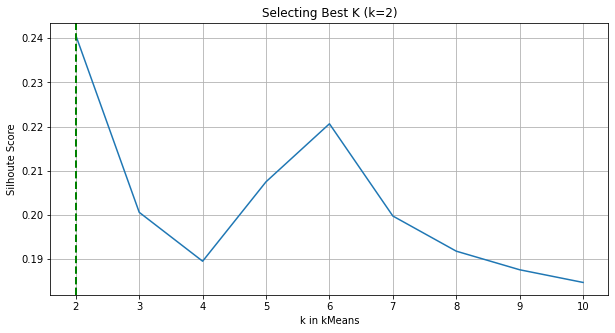

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x=list(cluster_labels.keys()), y=s_scores)
plt.axvline(x=2, linewidth=2, color='green', linestyle='--')
plt.title('Selecting Best K (k=2)')
plt.xlabel('k in kMeans')
plt.ylabel('Silhoute Score')
# plt.margins(y=0.5)
plt.grid()
plt.show()

<h3> Tuned k-Means Model</h3>

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)

kmeans.fit(X_oneHot.loc[train_index,:])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [ ]:
#   scores[clusters] = kmeans.inertia_
#cluster_labels[clusters] = kmeans.predict(X)
train_labels = kmeans.predict(X_oneHot.loc[train_index, :])

In [ ]:
cluster_1_index = []
cluster_2_index = []

for i,label in enumerate(train_labels):
    if label == 0:
        cluster_1_index.append(i)
    else:
        cluster_2_index.append(i)

In [ ]:
validate_labels = kmeans.predict(X_oneHot.loc[validate_index, :])

In [ ]:
# set(validate_labels)
cluster_1_index_val = []
cluster_2_index_val = []

for i,label in enumerate(validate_labels):
    if label == 0:
        cluster_1_index_val.append(i)
    else:
        cluster_2_index_val.append(i)

In [ ]:
# len(cluster_1_index) #--> 17178

len(cluster_2_index) # --> 26668

26668

<h3> Prepairing data for Modelling on clusters </h3>

In [ ]:
y_train = y[train_index].reset_index(drop=True)

In [ ]:
y_validate = y[validate_index].reset_index(drop=True)

In [ ]:
X_oneHot_cluster_1_train = X_oneHot.loc[train_index,:].reset_index(drop=True)
X_oneHot_cluster_1_train = X_oneHot_cluster_1_train.loc[cluster_1_index, :]

In [ ]:
X_oneHot_cluster_1_val = X_oneHot.loc[validate_index,:].reset_index(drop=True)
X_oneHot_cluster_1_val = X_oneHot_cluster_1_val.loc[cluster_1_index_val, :]

In [ ]:
X_oneHot_cluster_2_train = X_oneHot.loc[train_index,:].reset_index(drop=True)
X_oneHot_cluster_2_train = X_oneHot_cluster_2_train.loc[cluster_2_index, :]

In [ ]:
X_oneHot_cluster_2_val = X_oneHot.loc[validate_index,:].reset_index(drop=True)
X_oneHot_cluster_2_val = X_oneHot_cluster_2_val.loc[cluster_2_index_val, :]

## Decision Tree with Clustered Data

In [ ]:
min_samples = [2,3,5,7,9, 15, 21]
min_samples.extend([i for i in range(25,501,25)])

param_grid = {'max_depth': np.arange(2,21), 'min_samples_split': min_samples}
performance_metric = {'F1': 'f1', 'Accuracy': 'accuracy'}

In [ ]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced', random_state=1),
                  param_grid=param_grid, scoring=performance_metric,
                  refit='F1', return_train_score=True)

### return_train_score = False(default) --> No use for DT, can be used in Logistic like models to plot train vs Cv plot

<h4> Cluster 1 </h4>

In [ ]:
gs.fit(X_oneHot_cluster_1_train, y_train[cluster_1_index])

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=1, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,

In [ ]:
print('Best combination of Parameters')
print('-'*50)

for k, v in gs.best_params_.items():
    print(k,':',v)

print()

print('Best F1 score:\t', gs.best_score_)


Best combination of Parameters
--------------------------------------------------
max_depth : 19
min_samples_split : 2

Best F1 score:	 0.40996620939466694


In [ ]:
results = gs.cv_results_
results = pd.DataFrame(results)
#results

In [ ]:
################# Data needed for plotting #################### 
max_depths = results['param_max_depth']
min_samples = results['param_min_samples_split']
f1_scores_train = results['mean_train_F1']
f1_scores_test = results['mean_test_F1']


############ Data Frame for Seaborn Heatmap ########

f1_train_df = pd.DataFrame(data=np.column_stack([max_depths, min_samples,
                                                  f1_scores_train]
                                         ),
                            columns=['max_depth', 'min_samples', 'F1'], 
                            dtype=np.float  
                    )
# Pivot is needed for Seaborn Heatmap
f1_train_df = f1_train_df.pivot('max_depth', 'min_samples', 'F1')


f1_test_df = pd.DataFrame(data=np.column_stack([max_depths, min_samples,
                                                  f1_scores_test]
                                                 ),
                               columns=['max_depth', 'min_samples', 'F1'],
                            dtype = np.float
                        )
# Pivot is needed for Seaborn Heatmap
f1_test_df = f1_test_df.pivot('max_depth', 'min_samples', 'F1')

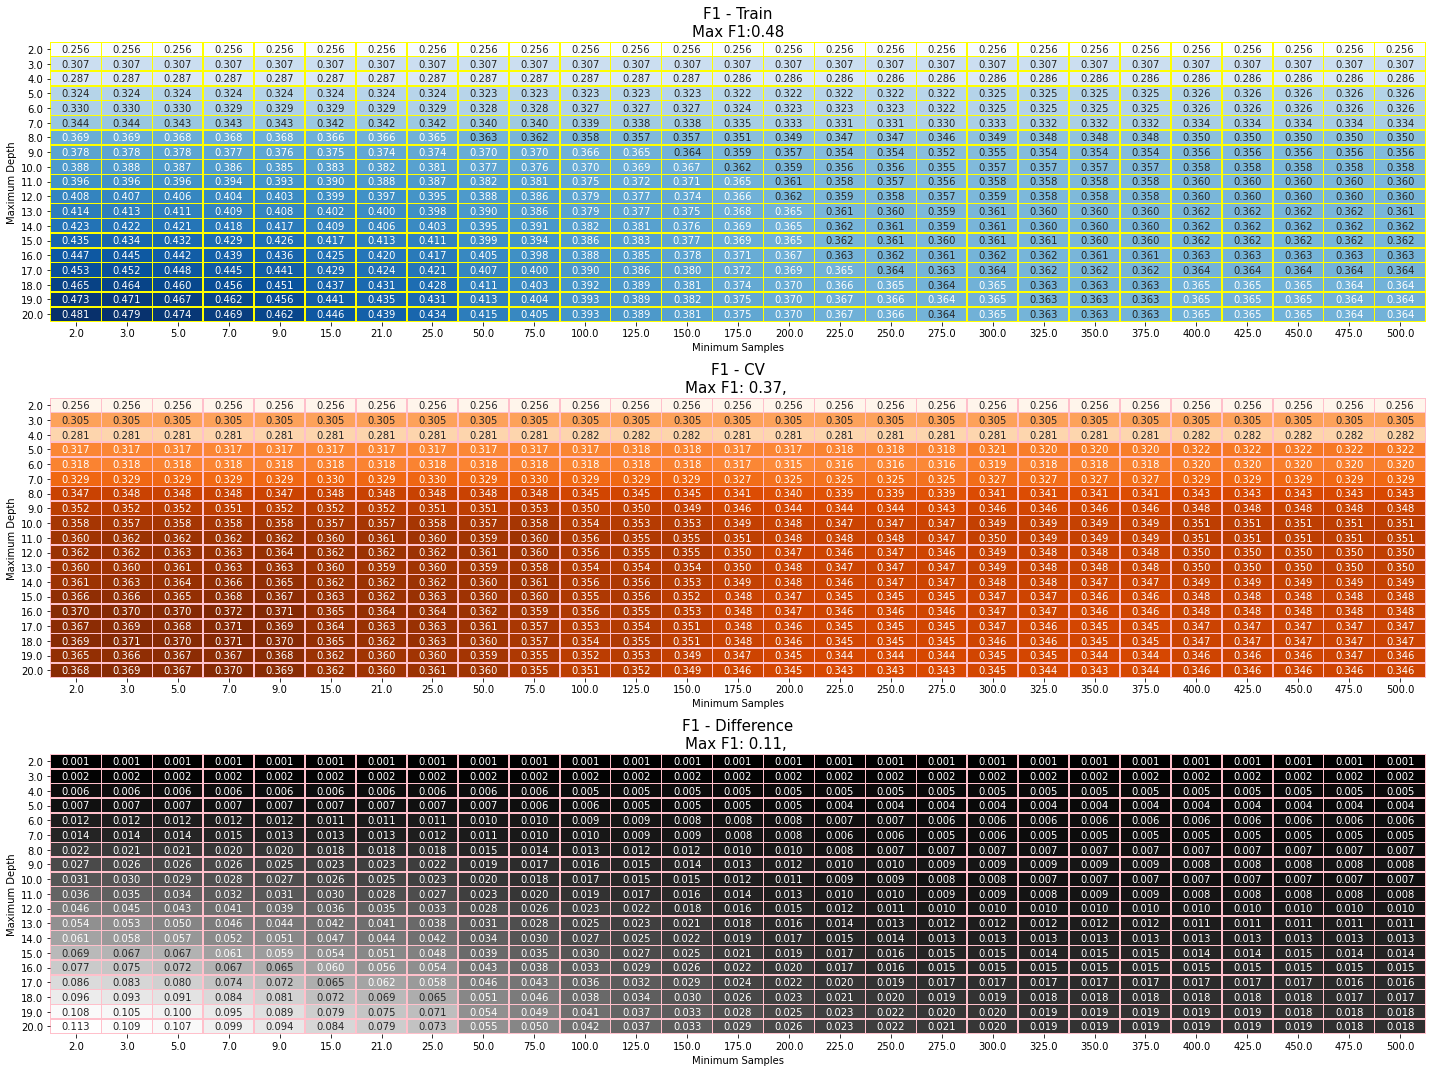

In [ ]:
########## PLOTS ##########

xlabel = 'Minimum Samples'
ylabel = 'Maximum Depth'

fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(20, 15))

#plt.subplot(ax[0])
axs = ax[0]
sns.heatmap(f1_train_df, annot=True, linewidths=0.5, cmap = plt.cm.Blues,
            linecolor='yellow', fmt='0.3f', cbar=False, ax=axs)
axs.set_title(f'F1 - Train\nMax F1:{max(f1_scores_train):.2f}', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

axs = ax[1]
sns.heatmap(f1_test_df, annot=True, linewidths=0.5, cmap = plt.cm.Oranges,
            linecolor='pink', fmt='0.3f', cbar=False, ax=axs)
axs.set_title(f'F1 - CV\nMax F1: {max(f1_scores_test):.2f}, ', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)


axs = ax[2]
diff_df = f1_train_df - f1_test_df
sns.heatmap(f1_train_df - f1_test_df, annot=True, linewidths=0.5, cmap = plt.cm.Greys_r,
            linecolor='pink', fmt='0.3f', cbar=False, ax=axs)

axs.set_title(f'F1 - Difference\nMax F1: {max(diff_df.max()):.2f}, ', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)
del diff_df


plt.tight_layout(h_pad=1)
plt.show()

<h4> Tuned Model for Cluster 1</h4>

Although best Hyper parameters were : \
   > max_depth : 19\
   > min_samples_split : 2

But chosen:  **min_samples = 15, max_depth = 10**. Because of better Trade - Off.

In [ ]:
# Tuned Decision Tree
tuned_DT = DecisionTreeClassifier(max_depth=10, min_samples_split=15, class_weight='balanced', random_state=1)
tuned_DT = tuned_DT.fit(X_oneHot_cluster_1_train, y_train[cluster_1_index])

In [ ]:
# calibrate the DT model
DT_calibarted = CalibratedClassifierCV(base_estimator=tuned_DT, cv='prefit')
DT_calibarted = DT_calibarted.fit(X_oneHot_cluster_1_train, y_train[cluster_1_index])

In [ ]:
y_pred = DT_calibarted.predict(X_oneHot_cluster_1_val)

In [ ]:
# F1: 0.5046197583511016
# Accuracy: 0.9364167122787812

# F1: 0.5752427184466019
# Accuracy: 0.9178596573574278
# seperate val data
print('F1:',f1_score(y_validate[cluster_1_index_val],
         y_pred))
print('Accuracy:', accuracy_score(y_validate[cluster_1_index_val],
         y_pred))

F1: 0.524271844660194
Accuracy: 0.9080028162403192


<h4> Cluster 2 </h4>

In [ ]:
gs.fit(X_oneHot_cluster_2_train, y_train[cluster_2_index])

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=1, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,

In [ ]:
print('Best combination of Parameters')
print('-'*50)

for k, v in gs.best_params_.items():
    print(k,':',v)

print()

print('Best F1 score:\t', gs.best_score_)


Best combination of Parameters
--------------------------------------------------
max_depth : 16
min_samples_split : 7

Best F1 score:	 0.3724965572197009


In [ ]:
results = gs.cv_results_
results = pd.DataFrame(results)
#results

In [ ]:
################# Data needed for plotting #################### 
max_depths = results['param_max_depth']
min_samples = results['param_min_samples_split']
f1_scores_train = results['mean_train_F1']
f1_scores_test = results['mean_test_F1']


############ Data Frame for Seaborn Heatmap ########

f1_train_df = pd.DataFrame(data=np.column_stack([max_depths, min_samples,
                                                  f1_scores_train]
                                         ),
                            columns=['max_depth', 'min_samples', 'F1'], 
                            dtype=np.float  
                    )
# Pivot is needed for Seaborn Heatmap
f1_train_df = f1_train_df.pivot('max_depth', 'min_samples', 'F1')


f1_test_df = pd.DataFrame(data=np.column_stack([max_depths, min_samples,
                                                  f1_scores_test]
                                                 ),
                               columns=['max_depth', 'min_samples', 'F1'],
                            dtype = np.float
                        )
# Pivot is needed for Seaborn Heatmap
f1_test_df = f1_test_df.pivot('max_depth', 'min_samples', 'F1')

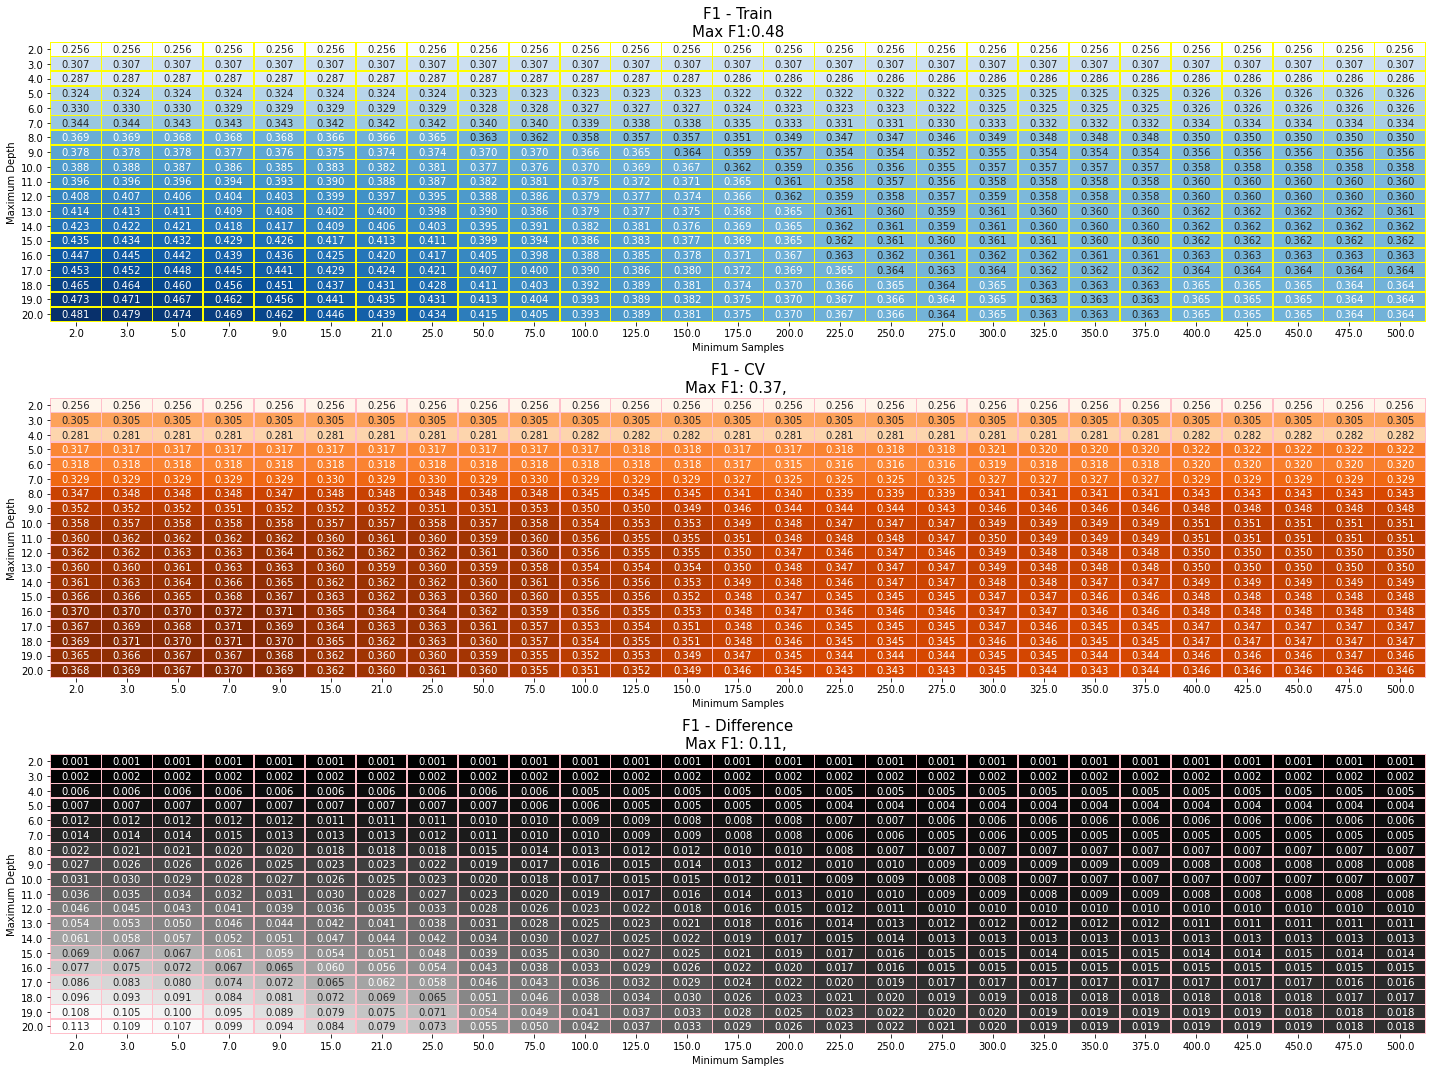

In [ ]:
########## PLOTS ##########

xlabel = 'Minimum Samples'
ylabel = 'Maximum Depth'

fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(20, 15))

#plt.subplot(ax[0])
axs = ax[0]
sns.heatmap(f1_train_df, annot=True, linewidths=0.5, cmap = plt.cm.Blues,
            linecolor='yellow', fmt='0.3f', cbar=False, ax=axs)
axs.set_title(f'F1 - Train\nMax F1:{max(f1_scores_train):.2f}', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

axs = ax[1]
sns.heatmap(f1_test_df, annot=True, linewidths=0.5, cmap = plt.cm.Oranges,
            linecolor='pink', fmt='0.3f', cbar=False, ax=axs)
axs.set_title(f'F1 - CV\nMax F1: {max(f1_scores_test):.2f}, ', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)


axs = ax[2]
diff_df = f1_train_df - f1_test_df
sns.heatmap(f1_train_df - f1_test_df, annot=True, linewidths=0.5, cmap = plt.cm.Greys_r,
            linecolor='pink', fmt='0.3f', cbar=False, ax=axs)

axs.set_title(f'F1 - Difference\nMax F1: {max(diff_df.max()):.2f}, ', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)
del diff_df


plt.tight_layout(h_pad=1)
plt.show()

<h4> Tuned Model for Cluster 1</h4>

Although best Hyper parameters were : \
   > max_depth : 16\
   > min_samples_split : 7

But chosen:  **min_samples = 75, max_depth = 11**. Because of better Trade - Off.

In [ ]:
# Tuned Decision Tree
tuned_DT = DecisionTreeClassifier(max_depth=11, min_samples_split=75, class_weight='balanced', random_state=1)
tuned_DT = tuned_DT.fit(X_oneHot_cluster_2_train, y_train[cluster_2_index])

In [ ]:
# calibrate the DT model
DT_calibarted = CalibratedClassifierCV(base_estimator=tuned_DT, cv='prefit')
DT_calibarted = DT_calibarted.fit(X_oneHot_cluster_2_train, y_train[cluster_2_index])

In [ ]:
y_pred = DT_calibarted.predict(X_oneHot_cluster_2_val)

In [ ]:
# F1: 0.5046197583511016
# Accuracy: 0.9364167122787812

# seperate val data
print('F1:',f1_score(y_validate[cluster_2_index_val],
         y_pred))
print('Accuracy:', accuracy_score(y_validate[cluster_2_index_val],
         y_pred))

F1: 0.4435946462715105
Accuracy: 0.9565736457245188


In [ ]:
print('Averaged F1 score of two clusters:')
print('-'*50)

print((0.524271844660194 + 0.4435946462715105) / 2)

Averaged F1 score of two clusters:
--------------------------------------------------
0.48393324546585226
